In [1]:
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
%run '/home/dpirvu/project/BH_triggered_VD/data/findSpectrum.py'

### Simulation Parameters 

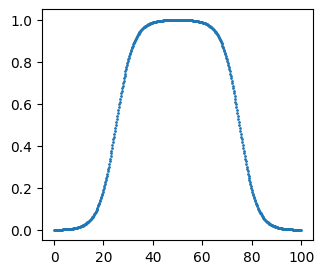

In [4]:
nLat = 512
lenLat = 100
lamb = 0.028
frac = 2.

# Make the lattice
spectrum = Spectrum(nLat, lenLat, lamb, frac)
xL, kL, knyq, dx, dk, invFTcoeffs, dirFTcoeffs = spectrum.getLattice()

fig, ax = plt.subplots(figsize = (3.5, 3))
plt.plot(xL, spectrum.Ux(lamb), 'o', ms=1)
plt.show()

In [5]:
phi0 = 2.*np.pi/10.
mean_phi = np.pi
V0 = 1.
m2Bare = 1.
delta = lambda m2: np.sqrt(m2 * phi0**2. / V0 + 1.); print(delta(m2Bare))

nTime = nLat
nSims = 10
nCols = 2
alpha = 8
dt = dx/alpha
dtout = dt*alpha

1.1810098120013968


In [6]:
sim_location = lambda sim, lamb: '/gpfs/dpirvu/dilatonBH/BEC_sim'+str(sim)+'_N'+str(nLat)+'_L'+str(int(lenLat))+'_lambda'+str('%.3f'%lamb)+'_fields.dat'
plot_location = '/home/dpirvu/project/dilaton_bh/plots/'
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

def extract_sim(nT, nL, sim, lamb):
    data = np.genfromtxt(sim_location(sim, lamb))
    simulation = [np.reshape(data[:,col], (nT, nL)) for col in range(nCols)]
    return np.asarray(simulation)

In [7]:
# Import data
try:
    if w2bare[0]:
        print(np.shape(transfMatrix))
except NameError:
        w2bare = np.genfromtxt('./data/frequencies'+'_N'+str(nLat)+'_L'+str(int(lenLat))+'_lambda'+str('%.3f'%lamb)+'.txt')[1:]
        mat = np.genfromtxt('./data/transfMatrix'+'_N'+str(nLat)+'_L'+str(int(lenLat))+'_lambda'+str('%.3f'%lamb)+'.txt')
        transfMatrix = np.reshape(mat[2:],(int(mat[0]),int(mat[1])))
        print('Done', np.shape(transfMatrix))

Done (257, 512)


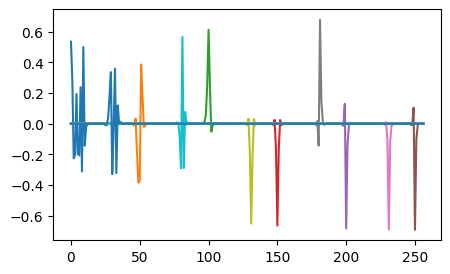

In [8]:
fig, ax = plt.subplots(figsize = (5, 3))
for ii in range(0, nLat//2, 50):
    plt.plot(transfMatrix[:,ii])
for ii in range(nLat//2+25, nLat, 50):
    plt.plot(transfMatrix[:,ii])
plt.show()

In [9]:
# Field power spectrum
norm = 1./ phi0 / np.sqrt(4. * lenLat)
w2free = lambda kL, m2: kL**2. + m2

# Free field (constant mass term) field modes \phi_k
free_eigenbasis = norm / w2free(kL, 1.)**0.25 / np.sqrt(np.exp(2.*np.pi*w2free(kL,1.)**0.5/lamb) - 1.)
free_eigenbasis[kL==0]=0.

# Vacuum field
eigenbasis = norm / w2bare**0.25 / np.sqrt(np.exp(2.*np.pi*w2bare**0.5/lamb) - 1.)
eigenbasis[0]=0.
# Coordinate transformation of field modes \phi_k into momentum basis
spectral_field = np.dot(np.transpose(transfMatrix), eigenbasis)

#Compute full field \phi(x) as the inverse FT of the \phi_k's
free_field_fluctuations = np.tensordot(free_eigenbasis, np.exp(-1j*np.outer(xL, kL)), axes=(0,0))
field_fluctuations = np.tensordot(spectral_field, np.exp(-1j*np.outer(xL, kL)), axes=(0,0))

#Power spectrum of field in the BH background
pspec = np.abs(spectral_field)**2
fluct_variance = np.sum(pspec)

th_masses = lambda m2, lamb: m2 + 0.5 * lamb * fluct_variance
omega2_fit = lambda k, m2: k**2. + m2

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


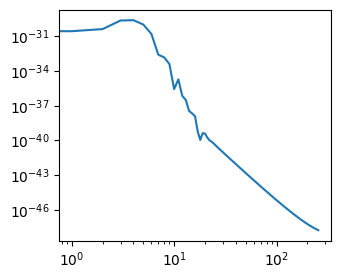

In [10]:
fig, ax = plt.subplots(figsize = (3.5, 3))
plt.loglog(pspec[:knyq])
plt.show()

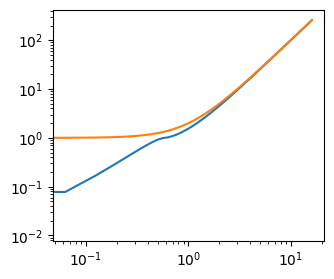

In [11]:
fig, ax = plt.subplots(figsize = (3.5, 3))
plt.loglog(kL[:knyq-1], w2bare[:knyq-1])
plt.loglog(kL[:knyq-1], w2free(kL, m2Bare)[:knyq-1])
plt.show()

1.1810098120013968 1.3824337486128733e-29
7.436218793480659


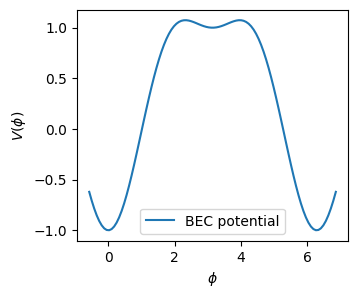

In [12]:
V = lambda phi, m2: 0.5*m2*phi**2.
Vbec = lambda phi, m2: V0 * (-np.cos(phi) + 0.5 * delta(m2)**2 * np.sin(phi)**2)
# V_0=1.; phi0=1.; m2bare = V''(phi/phi0=np.pi)
# Which gives:
# m2BEC = V0 * phi0**-2. * (delta**2. -1.)
# Therefore we can obtain delta from this: delta = np.sqrt(phi0**2. * V0**-1. * m2test + 1.)
print(delta(m2Bare), fluct_variance)
multi = 1e15
if True:
    phiList = np.linspace(mean_phi-multi*np.sqrt(fluct_variance), mean_phi+multi*np.sqrt(fluct_variance), 100)
    print(phiList[-1]-phiList[0])
#    plt.plot(phiList, [V(phi-mean_phi, m2Bare) for phi in phiList], label='non-interacting')
#    plt.plot(phiList, [Vbec(phi, delta(m2Bare))+(V(0,m2Bare)-Vbec(mean_phi,delta(m2Bare))) for phi in phiList], label='BEC potential + constant')
    fig, ax = plt.subplots(figsize = (3.5, 3))
    plt.plot(phiList, Vbec(phiList, delta(m2Bare)), label='BEC potential')
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$V(\phi)$')
    plt.legend()
    plt.show()

In [14]:
all_data = np.asarray([extract_sim(nTime, nLat, sim, lamb) for sim in range(nSims)])
print('Done')
print(np.shape(all_data))

Done
(10, 2, 512, 512)


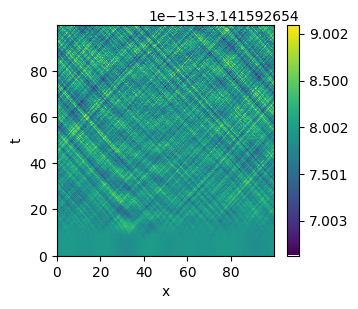

In [16]:
ext = [xL[0], xL[-1], xL[0]/dx*dtout, xL[-1]/dx*dtout]
sim = 0
fig, ax = plt.subplots(figsize = (3.5, 3))
im0 = ax.imshow(all_data[sim][0], aspect='auto', interpolation='none', extent = ext, origin='lower')
clb = plt.colorbar(im0, ax = ax)
plt.xlabel('x')
plt.ylabel('t')
plt.show()